In [110]:
import pandas as pd
import numpy as np
import xgboost as xg

In [111]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import time
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [112]:
from sklearn.multiclass import OneVsOneClassifier

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import f1_score, accuracy_score

from time import gmtime, strftime

import textcleaner as tc

import re

In [114]:
def clean_summary(text):
    text = re.sub("\'", "", text)
    text = re.sub("<BR>"," ",text)
    text = re.sub("[^a-zA-Z]"," ",text)
#     text = re.sub("(\W|_)+"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [115]:

def rem_stop_words(df):
    for i in range (len(df)):
        data = tc.document(df['text'][i])
        df['text'][i] = str(data.remove_stpwrds())
        
def prepare_data(df):
#     df[['First_persone', 'Second_persone']] = df['dialogue'].str.split('<BR>', 1, expand=True)
    df['text'] = df['dialogue'].apply(clean_summary)
#     df['First_persone'] = df['First_persone'].apply(clean_summary)
#     df['Second_persone'] = df['Second_persone'].apply(clean_summary)
#     df['text'] = df[['First_persone', 'Second_persone']].apply(lambda x: ''.join(x), axis=1)

def prepare_genres(df):
    df["genres"] = df["genres"].apply(eval)
    genres = []
    for i in df['genres']:
        genres.append(i)
    df['genre_new'] = genres
    df['GenreString'] = df['genre_new'].apply(lambda x: ' '.join(x))
    
# def train_data(df_tr, df_te):
#     x_train = df_tr['text']
#     multilabel_binarizer = MultiLabelBinarizer()
#     multilabel_binarizer.fit(df_train['genre_new'])
#     y = multilabel_binarizer.transform(df_train['genre_new'])    
#     tfidf_vectorizer = TfidfVectorizer()
#     xtrain = tfidf_vectorizer.fit_transform(x_train)
#     lr = LogisticRegression()
#     clf = OneVsRestClassifier(lr)
#     clf.fit(xtrain, y)

In [116]:
df_train = pd.read_csv('train.csv')

In [117]:
# list(df_train[df_train['movie'] == 3]['genres'])

In [118]:
# set(df_train[df_train['movie'] == 3]['GenreString'])

In [119]:
# df_train[df_train['id'] == 21579]['dialogue']

In [120]:
# df_train.groupby(['movie']).agg(lambda x: len(set(x)) == 1)['GenreString']

In [121]:
# inf = pd.DataFrame(list(df_train.groupby(['movie']).agg(lambda x: len(set(x)) == 1)['GenreString']))
# inf.value_counts().plot(kind='bar')

In [122]:
# df_train['movie'].value_counts().plot(kind='bar')

In [123]:
# df_train[df_train['movie'] == 482]

In [124]:
prepare_genres(df_train)
prepare_data(df_train)
# rem_stop_words(df_train)

In [125]:
output = []
for i in range(len(df_train)):
    for j in df_train['genres'][i]:
        output.append([j])
df_x=pd.DataFrame(output)

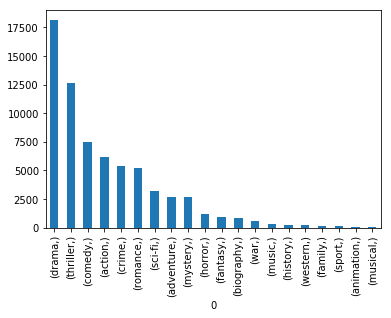

In [126]:
df_x.value_counts().plot(kind='bar')

In [127]:
y_train_in = df_train['GenreString'] 
def convert_cat(y_train_in):
    cv= CountVectorizer()
    cv.fit_transform(y_train_in)
    y_train=cv.transform(y_train_in)
    return y_train, cv
y_train, cv = convert_cat(y_train_in)

In [128]:
df_test = pd.read_csv('test.csv')
prepare_data(df_test)
# rem_stop_words(df_test)

In [130]:
x_train_in = df_train['text']
x_test_in = df_test['text']
def convert_feat(x_train_in, x_test_in):
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vectorizer.fit_transform(x_train_in.values)
    
    х_train = tfidf_vectorizer.transform(x_train_in.values)
    x_test = tfidf_vectorizer.transform(x_test_in.values)
    
    return х_train, x_test, tfidf_vectorizer
х_train, x_test, tfidf_vectorizer = convert_feat(x_train_in, x_test_in)

In [131]:
def cross_validation (x_train, y_train, model, folds):
    
    cv = KFold(n_splits=folds, random_state=1, shuffle=True)
    scores = cross_val_score(model, х_train, y_train, scoring='f1_samples', cv=cv)

    print(' Mean F1-Score: %.5f' % (mean(scores)))

In [132]:
# model1 = xg.XGBClassifier()
# clf = OneVsRestClassifier(model1)

In [135]:
cross_validation (х_train, y_train, clf, 3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


 Mean F1-Score: 0.41613


In [136]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(х_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [137]:
def genre_if_none2(i, threshold):
    texxt = df_test['text'][i]
    t_p = clf.predict_proba(tfidf_vectorizer.transform([texxt]))
    res2 = cv.inverse_transform(t_p)
    passed_the_threshold = res2[0][clf.predict_proba(x_test)[i] >= threshold]
    res = ' '.join(map(str, passed_the_threshold)) 
    return res

In [140]:
genre_if_none2(1, 0.3)

'drama'

In [141]:
def genre_if_none(i):
    texxt = df_test['text'][i]
    t_p = clf.predict_proba(tfidf_vectorizer.transform([texxt]))
    res = cv.inverse_transform(t_p)
    best_n = np.argsort(-t_p, axis=1)
    res2 = res[0][best_n[0][0]]+' '+res[0][best_n[0][1]]
    return res2

In [142]:
df_ss = pd.read_csv('sample_submission_most_popular.csv')

In [143]:

for i in tqdm(range(len(df_ss))):
    df_ss['genres'][i] = genre_if_none2(i, 0.3)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
len(df_ss[df_ss['genres'] == ''])

34

In [145]:
for i in tqdm(range(len(df_ss))):
    if df_ss['genres'][i] == '':
        df_ss['genres'][i] = genre_if_none(i)        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
i = strftime("Date_%m-%d Time_%H-%M", gmtime())

In [147]:
i

'Date_11-11 Time_13-35'

In [148]:
df_ss.to_csv('OutputFile '+ i +'.csv', index = None)

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from stop_words import get_stop_words

filtered_words = [word for word in df_train['text'] if word not in get_stop_words('english')]

In [ ]:
df_train['text']

In [ ]:
import nltk
nltk.download()

In [ ]:
# tfidf_vectorizer.inverse_transform(x_test[0])

In [ ]:
# t[9401]

In [ ]:
# clf.predict_proba(xtest)[9401]

In [ ]:
# def get_top_k_predictions(model,X_test,k):
    
#     # get probabilities instead of predicted labels, since we want to collect top 3
#     probs = model.predict_proba(X_test)

#     # GET TOP K PREDICTIONS BY PROB - note these are just index
#     best_n = np.argsort(-probs, axis=1)[:,:k]
    
#     # GET CATEGORY OF PREDICTIONS
#     preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
#     preds=[ item[::-1] for item in preds]
    
#     return cv.inverse_transform(preds)

In [ ]:
# x_train = df_train['text']
# multilabel_binarizer = MultiLabelBinarizer()
# multilabel_binarizer.fit(df_train['genre_new'])
# y = multilabel_binarizer.transform(df_train['genre_new'])    
# tfidf_vectorizer = TfidfVectorizer()
# xtrain = tfidf_vectorizer.fit_transform(x_train)
# xtrain1 = df_train['text']
# lr = LogisticRegression()
# clf = OneVsRestClassifier(lr)
# clf.fit(xtrain, y)